## Make The Imports...

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import warnings
warnings.filterwarnings('ignore')

## Data Exploration

In [141]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [142]:
train.head()

,tweet_id,safe_text,label,agreement
0,CL1KWCMY,Me &amp; The Big Homie meanboy3000 #MEANBOY #M...,0.0,1.0
1,E3303EME,I'm 100% thinking of devoting my career to pro...,1.0,1.0
2,M4IVFSMS,"#whatcausesautism VACCINES, DO NOT VACCINATE Y...",-1.0,1.0
3,1DR6ROZ4,I mean if they immunize my kid with something ...,-1.0,1.0
4,J77ENIIE,Thanks to <user> Catch me performing at La Nui...,0.0,1.0


In [143]:
  test.head()

,tweet_id,safe_text
0,00BHHHP1,<user> <user> ... &amp; 4 a vaccine given 2 he...
1,00UNMD0E,Students starting school without whooping coug...
2,01AXPTJF,"I'm kinda over every ep of <user> being ""rippe..."
3,01HOEQJW,How many innocent children die for lack of vac...
4,01JUKMAO,"CDC eyeing bird flu vaccine for humans, though..."


In [144]:
# check for missing values
train.isnull().sum()

,0
tweet_id,0
safe_text,0
label,1
agreement,2


In [145]:
train.dropna(inplace=True)

In [146]:
# Check unique labels in the training dataset
print("Unique labels in the train dataset:")
print(train['label'].unique())

# Find rows with invalid labels
invalid_labels = train[~train['label'].isin([-1, 0, 1])]
print(f"\nNumber of rows with invalid labls: {len(invalid_labels)}")
print(invalid_labels)

Unique labels in the train dataset:
[ 0.  1. -1.]

Number of rows with invalid labls: 0
Empty DataFrame
Columns: [tweet_id, safe_text, label, agreement]
Index: []


Label Distribution:
label
-1.0    1038
 0.0    4908
 1.0    4053
Name: count, dtype: int64


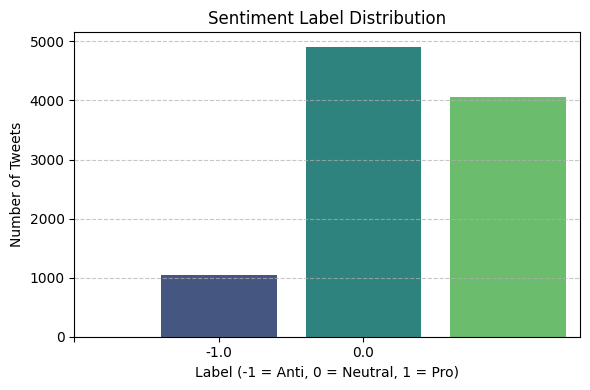

In [147]:
# Count the number of samples per class
label_counts = train['label'].value_counts().sort_index()

# Print the counts
print("Label Distribution:")
print(label_counts)

# Plot the distribution
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title("Sentiment Label Distribution")
plt.xlabel("Label (-1 = Anti, 0 = Neutral, 1 = Pro)")
plt.ylabel("Number of Tweets")
plt.xticks([-1, 0, 1])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [148]:
from collections import Counter

#Tokenize per row
train['tokens'] = train['safe_text'].str.split()

# Initialize containers
top_n = 10
bottom_n = 10
results = {}

# Loop through each label
for lbl in sorted(train['label'].unique()):
    # Flatten all tokens for this label
    all_tokens = [tok for tokens in train.loc[train['label']==lbl, 'tokens']
                       for tok in tokens]
    ctr = Counter(all_tokens)

    # Get most and least common
    most = ctr.most_common(top_n)
    # least: words that occur only once up to bottom_n, then in ascending order
    # here we sort items by (count, word) and take the first bottom_n
    least = sorted(ctr.items(), key=lambda x: (x[1], x[0]))[:bottom_n]

    results[lbl] = {'most_common': most, 'least_common': least}

# Display results
for lbl, freq in results.items():
    print(f"\n=== Label {lbl} ===")
    print("Top 10 words:")
    for word, count in freq['most_common']:
        print(f"  {word:15} {count}")
    print("\nBottom 10 words:")
    for word, count in freq['least_common']:
        print(f"  {word:15} {count}")


=== Label -1.0 ===
Top 10 words:
  <user>          690
  <url>           443
  the             430
  to              330
  of              243
  a               220
  I               191
  and             186
  in              183
  vaccine         171

Bottom 10 words:
  !!              1
  !!!!!           1
  "...there       1
  "Anti           1
  "Bad            1
  "Essential      1
  "Every          1
  "Great,         1
  "HPV            1
  "I              1

=== Label 0.0 ===
Top 10 words:
  <url>           2482
  <user>          2098
  the             1624
  to              1433
  measles         1214
  in              1008
  of              1005
  a               918
  and             877
  I               758

Bottom 10 words:
  !!!!            1
  !😂😂😂            1
  "ACTUAL         1
  "ANDREA"ed      1
  "All            1
  "Anti-vaxx      1
  "At             1
  "Bieber         1
  "Big            1
  "Body           1

=== Label 1.0 ===
Top 10 words:
  <user>         

## Preprocessing & Feature Engineering

In [149]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [150]:
# Drop rows with missing values in text columns
train.dropna(subset=['safe_text'], inplace=True)
test.dropna(subset=['safe_text'], inplace=True)

# Reset index after drops
train.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [151]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()                                      # lowercase
    text = re.sub(r'@\w+', '', text)                              # remove usernames
    text = re.sub(r'http\S+|www\S+', '', text)                    # remove links
    text = re.sub(rf"[{string.punctuation}]", '', text)           # remove punctuation
    text = re.sub(r'\d+', '', text)                               # remove digits
    text = re.sub(r'\s+', ' ', text).strip()                      # remove extra whitespace
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [152]:
import string


# Apply clean_text() to train and test data
train['cleaned_text'] = train['safe_text'].apply(clean_text)
test['cleaned_text'] = test['safe_text'].apply(clean_text)

## Model Training & Evaluation

In [153]:
# Split your data
X_train, X_test, y_train, y_test = train_test_split(train['cleaned_text'], train['label'], test_size=0.2, random_state=42)

In [154]:
print(X_train.shape)
print(X_test.shape)

(7999,)
(2000,)


### Feature Extraction (Vectorization)

In [155]:
tfv = TfidfVectorizer(min_df=3,  max_features=None,
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=True,smooth_idf=True,sublinear_tf=True,
            stop_words = 'english')

In [156]:
# Fit and transform TF-IDF to the training set
X_train_tfidf = tfv.fit_transform(X_train)

# Transform the test set for evaluation
X_test_tfidf_eval = tfv.transform(X_test)

# Transform test data (cleaned_text column) for prediction
X_test_tfidf_pred = tfv.transform(test['cleaned_text'])

## Training

In [157]:
model = LogisticRegression(max_iter=1000, random_state=42)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, random_state=42)

## Evaluation (using RMSE).

In [158]:
val_predictions_proba = model.predict_proba(X_test_tfidf_eval)

In [159]:
def process_prediction(preds):
    return [(pred.argmax() - 1) * pred[pred.argmax()] for pred in preds]

In [160]:
val_prediction = process_prediction(val_predictions_proba)

In [161]:
# Print RMSE
rmse = np.sqrt(mean_squared_error(y_test, val_prediction))
print(f"Validation RMSE: {rmse:.4f}")

Validation RMSE: 0.6051


## Generate and Submit Predictions

In [162]:
test_predictions_proba = model.predict_proba(X_test_tfidf_pred)

In [163]:
test_prediction = process_prediction(test_predictions_proba)

In [164]:
# Prepare submission dataframe
submission = pd.DataFrame({
    "tweet_id": test["tweet_id"],
    "label": test_prediction  # Float values as required by RMSE metric
})

# Save to CSV for submission
submission.to_csv("submission.csv", index=False)

In [165]:
submission.head()

,tweet_id,label
0,00BHHHP1,0.453625
1,00UNMD0E,0.000000
2,01AXPTJF,0.000000
3,01HOEQJW,0.849670
4,01JUKMAO,0.000000
